In [ ]:
# This demo shows how to register 3D images with an anatomy-agnostic SynthMorph
# model trained without real images. Further information: https://synthmorph.io.
#
# If you find the demo useful, please cite:
#
#     SynthMorph: learning contrast-invariant registration without acquired images
#     Hoffmann M, Billot B, Greve DN, Iglesias JE, Fischl B, Dalca AV
#     IEEE Transactions on Medical Imaging (TMI), 41 (3), 543-558, 2022
#     https://doi.org/10.1109/TMI.2021.3116879
#     https://arxiv.org/abs/2004.10282
#
#     Learning MRI contrast-agnostic registration
#     Hoffmann M, Billot B, Iglesias JE, Fischl B, Dalca AV
#     IEEE International Symposium on Biomedical Imaging (ISBI), 899-903, 2021
#     https://doi.org/10.1109/ISBI48211.2021.9434113
#     https://synthmorph.io/#papers (PDF)
#
# We distribute this notebook under the "2-clause BSD" license:
# https://choosealicense.com/licenses/bsd-2-clause

In [ ]:
# Packages from GitHub.
!pip -q install git+https://github.com/adalca/neurite.git@0776a575eadc3d10d6851a4679b7a305f3a31c65
!pip -q install git+https://github.com/freesurfer/surfa.git@977f6eaa9689f1c2730f206b9ea7e74845b34ff6
!pip -q install git+https://github.com/voxelmorph/voxelmorph.git@375a1492bb8781cbbaf22f0ca2973e5121484f99

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import surfa as sf
import tensorflow as tf
import voxelmorph as vxm
import matplotlib.pyplot as plt

In [ ]:
# Downloads. We use unprocessed T1-weighted MRI data from subject Afterthought
# in Mindboggle-101 (https://mindboggle.info/) and T2-weighted MRI from subject
# fsm27uz in FSM (https://surfer.nmr.mgh.harvard.edu/fswiki/FsmData/).
%%sh
curl -O https://surfer.nmr.mgh.harvard.edu/docs/synthmorph/images/t1.nii.gz
curl -O https://surfer.nmr.mgh.harvard.edu/docs/synthmorph/images/t2.nii.gz
curl -O https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9728k  100 9728k    0     0  6915k      0  0:00:01  0:00:01 --:--:-- 6919k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.4M  100 12.4M    0     0  9622k      0  0:00:01  0:00:01 --:--:-- 9626k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 81.2M  100 81.2M    0     0  12.6M      0  0:00:06  0:00:06 --:--:-- 14.5M


In [ ]:
# Helper functions. The shape has to be divisible by 16.
shape = (128, 128, 128)

def normalize(x):
    x = np.float32(x)
    x -= x.min()
    x /= x.max()
    return x[None, ..., None]


def show(x, title=None):
  x = np.squeeze(x)
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  i, j, k = (f // 2 for f in x.shape)

  slices = x[:, j, :], x[:, :, k], x[i, :, :].T
  for x, ax in zip(slices, axes):
    ax.imshow(x, cmap='gray')
    ax.set_axis_off()

  if title:
    axes[1].text(0.50, 1.05, title, ha='center', transform=axes[1].transAxes, size=14)

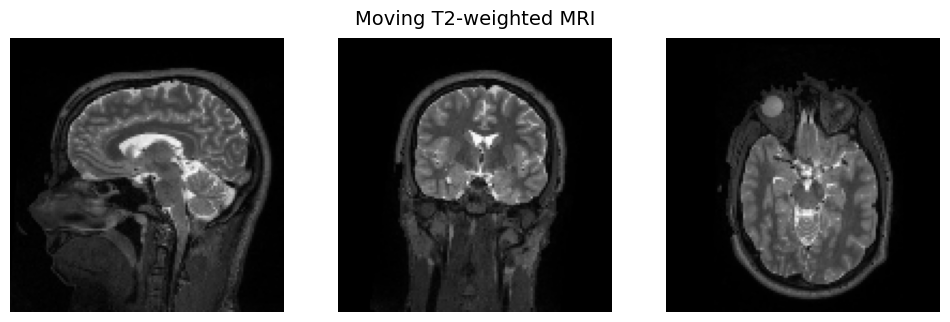

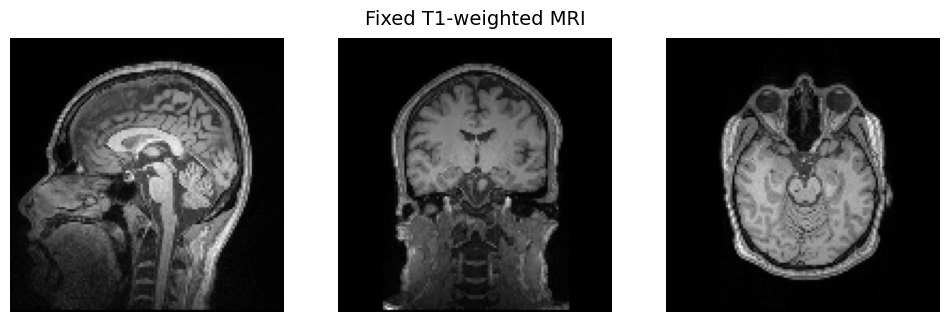

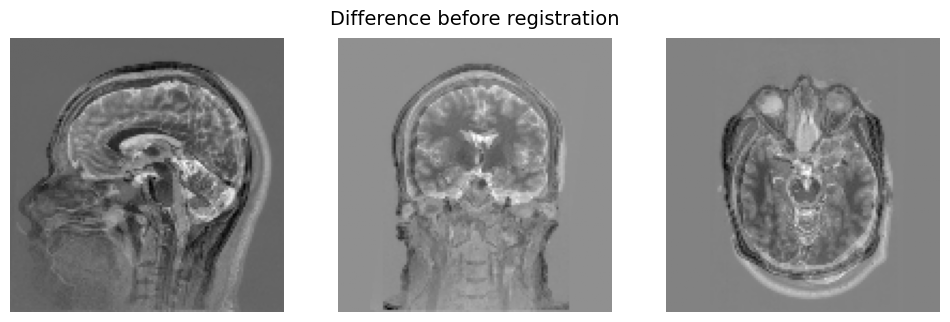

In [ ]:
# Difference before registration.
t1 = sf.load_volume('t1.nii.gz').resize(voxsize=2).reshape(shape).reorient('ILP')
t2 = sf.load_volume('t2.nii.gz').resample_like(t1)
before = normalize(t2) - normalize(t1)

show(t2, title='Moving T2-weighted MRI')
show(t1, title='Fixed T1-weighted MRI')
show(before, title='Difference before registration')

In [ ]:
# Shapes model. Assumes affine initialization and may require fine tuning.
model = vxm.networks.VxmDense(
    nb_unet_features=([256] * 4, [256] * 6),
    int_steps=5,
    int_resolution=2,
    svf_resolution=2,
    inshape=shape,
  )
model = tf.keras.Model(model.inputs, model.references.pos_flow)
model.load_weights('shapes-dice-vel-3-res-8-16-32-256f.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 110s 110s/step


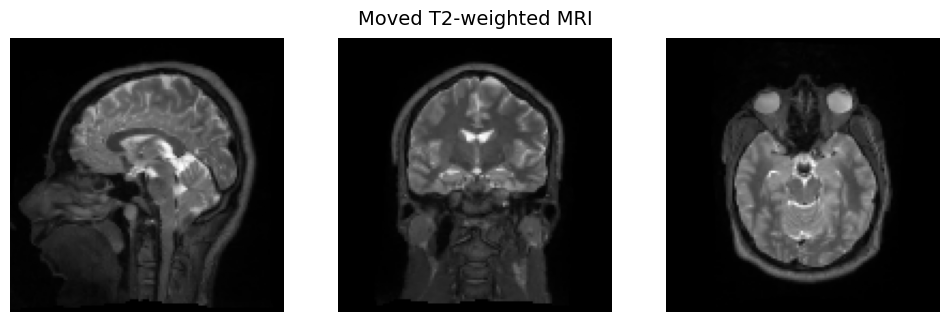

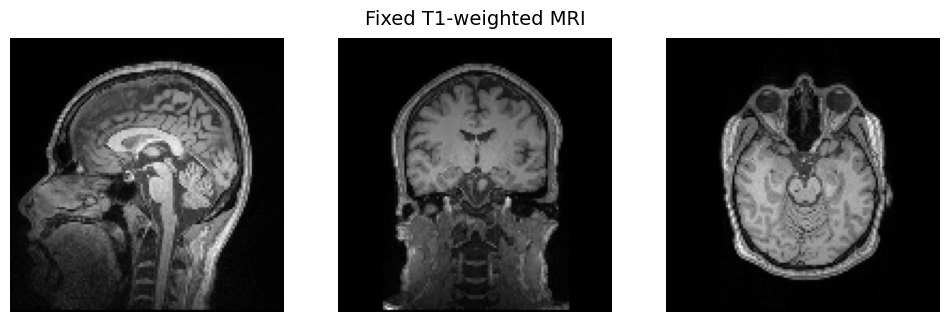

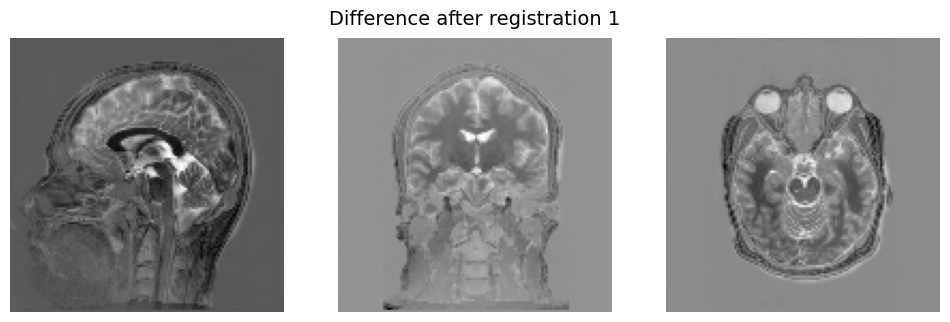

In [ ]:
# Registration 1.
moving = normalize(t2)
fixed = normalize(t1)
trans = model.predict((moving, fixed))

moved = vxm.layers.SpatialTransformer(fill_value=0)((moving, trans))
show(moved, title='Moved T2-weighted MRI')
show(fixed, title='Fixed T1-weighted MRI')
show(moved - fixed, title='Difference after registration 1')

1/1 ━━━━━━━━━━━━━━━━━━━━ 104s 104s/step


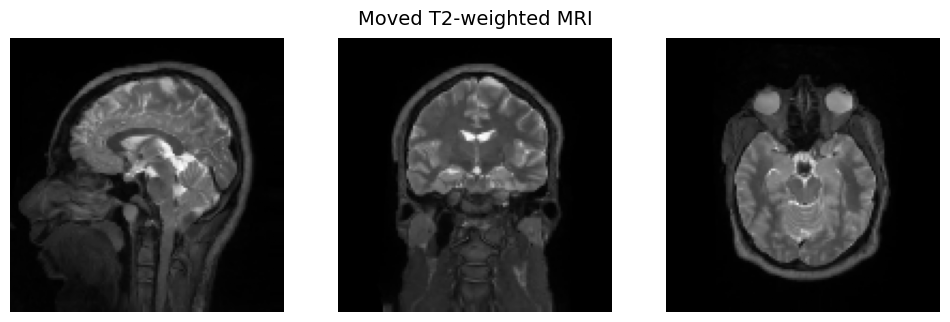

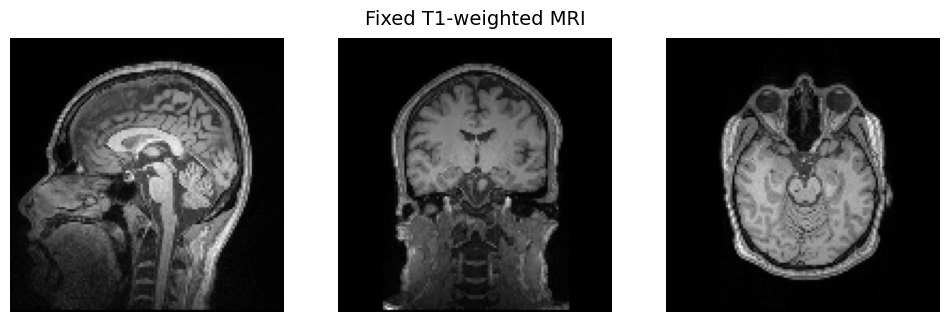

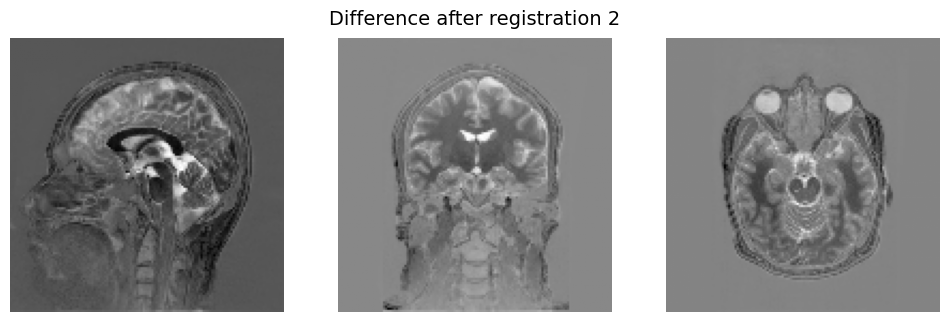

In [ ]:
# Registration 2.
resid = model.predict((moved, fixed))
trans = vxm.layers.ComposeTransform()((trans, resid))

moved = vxm.layers.SpatialTransformer(fill_value=0)((moving, trans))
show(moved, title='Moved T2-weighted MRI')
show(fixed, title='Fixed T1-weighted MRI')
show(moved - fixed, title='Difference after registration 2')

In [ ]:
# Save results.
t1.new(moved[0]).save('moved.nii.gz')
sf.Warp(trans[0], source=t2, target=t1, format=sf.Warp.Format.disp_crs).save('warp.nii.gz')